In [10]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

In [11]:
input_window = 100
output_window = 5
batch_size = 32 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):

        return x + self.pe[:x.size(0), :]

In [13]:
class TransAm(nn.Module):
    def __init__(self,feature_size=10,num_layers=3,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            # print('a',src.size())
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        # print('j',src.size(),self.src_mask.size())
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)

        output = self.decoder(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [14]:
import pandas as pd
from datetime import date
data_ = pd.read_excel('../data/MultiTSData.xlsx', 'Sheet1', parse_dates=["date"])


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) 
data = data_.loc[
    (data_["date"] >= pd.Timestamp(date(2014, 1, 1))) & (data_["date"] <= pd.Timestamp(date(2014, 2, 10)))]
# (3936, 10),10维变量
data = data.loc[:, "MT_200":"MT_209"]
print(data.shape)
series = data.to_numpy()
amplitude = scaler.fit_transform(series)
# print(amplitude.shape)
# print(amplitude)
# amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

(3936, 10)


In [16]:
from sklearn.preprocessing import MinMaxScaler
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw,:][:-output_window,:] , np.zeros((output_window,10)),axis=0)
        train_label = input_data[i:i+tw,:]
        # print(train_seq.shape,train_label.shape)
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)


def get_data():
    time        = np.arange(0, 400, 0.1)
    # amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    
    # series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    data = data_.loc[
        (data_["date"] >= pd.Timestamp(date(2014, 1, 1))) & (data_["date"] <= pd.Timestamp(date(2014, 2, 10)))]
    data = data.loc[:, "MT_200":  "MT_209"]
    series = data.to_numpy()
    # print('a',series.shape)
    amplitude = scaler.fit_transform(series)
    # print('b', amplitude.shape)
    # amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    
    samples = 2800
    train_data = amplitude[:samples]
    test_data = amplitude[samples:]

    train_sequence = create_inout_sequences(train_data,input_window)
    # print('a',train_sequence.size())
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device),scaler

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)).squeeze()# 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1)).squeeze()
    return input, target

In [17]:
train_data, val_data,scaler = get_data()
print(train_data.size())
# print(train_data.size(), val_data.size())
tr,te = get_batch(train_data, 0,batch_size)
print(tr.shape,te.shape)

torch.Size([2695, 2, 100, 10])
torch.Size([100, 32, 10]) torch.Size([100, 32, 10])


In [18]:
def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [19]:
def plot_and_loss(eval_model, data_source,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)

            # look like the model returns static values for the output window
            output = eval_model(data)   

            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            
            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)
    
    print(test_result.size(),truth.size())
    test_result=scaler.inverse_transform(test_result.reshape(-1, 1)).reshape(-1)
    truth=scaler.inverse_transform(truth.reshape(-1, 1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.axhline(y=0, color='k')
    pyplot.xlabel("Periods")
    pyplot.ylabel("Y")
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


def predict_future(eval_model, data_source,steps,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    
    data=scaler.inverse_transform(data.reshape(-1, 1)).reshape(-1)
    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%epoch)
    pyplot.close()
        
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich 
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data) 
            print(output[-output_window:].size(),targets[-output_window:].size())
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

In [20]:
def plot(eval_model, data_source,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)            
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)
    
    test_result_=scaler.inverse_transform(test_result[:700])
    truth_=scaler.inverse_transform(truth)
    print(test_result.shape,truth.shape)
    for m in range(9):
        test_result = test_result_[:,m]
        truth = truth_[:,m]
        fig = pyplot.figure(1, figsize=(20, 5))
        fig.patch.set_facecolor('xkcd:white')
        pyplot.plot([k + 510                 for k in range(190)],test_result[510:],color="red")
        pyplot.title('Prediction uncertainty')
        pyplot.plot(truth[:700],color="black")
        pyplot.legend(["prediction", "true"], loc="upper left")
        ymin, ymax = pyplot.ylim()
        pyplot.vlines(510, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        pyplot.ylim(ymin, ymax)
        pyplot.xlabel("Periods")
        pyplot.ylabel("Y")
        pyplot.show()
        pyplot.close()
    return total_loss / i

/home/yinke/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    16/   84 batches | lr 0.005000 | 150.64 ms | loss 0.27135 | ppl     1.31
| epoch   1 |    32/   84 batches | lr 0.005000 | 140.67 ms | loss 0.22348 | ppl     1.25
| epoch   1 |    48/   84 batches | lr 0.005000 | 144.10 ms | loss 0.27898 | ppl     1.32
| epoch   1 |    64/   84 batches | lr 0.005000 | 162.01 ms | loss 0.24816 | ppl     1.28
| epoch   1 |    80/   84 batches | lr 0.005000 | 145.92 ms | loss 0.22669 | ppl     1.25
torch.Size([1030, 10]) torch.Size([1030, 10])


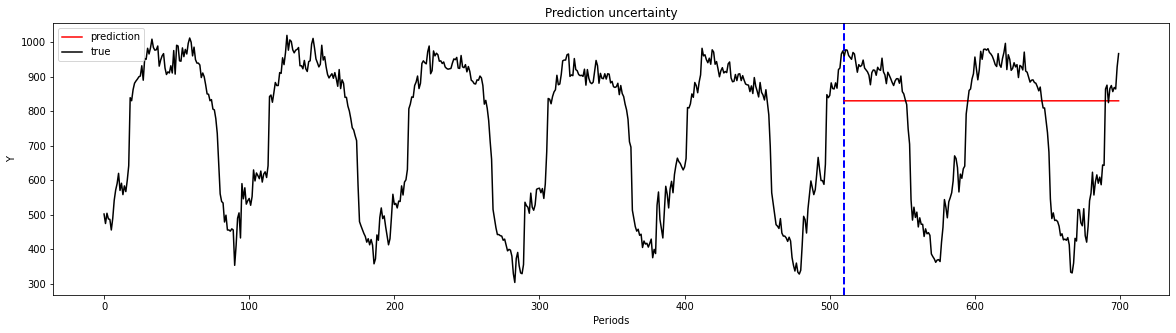

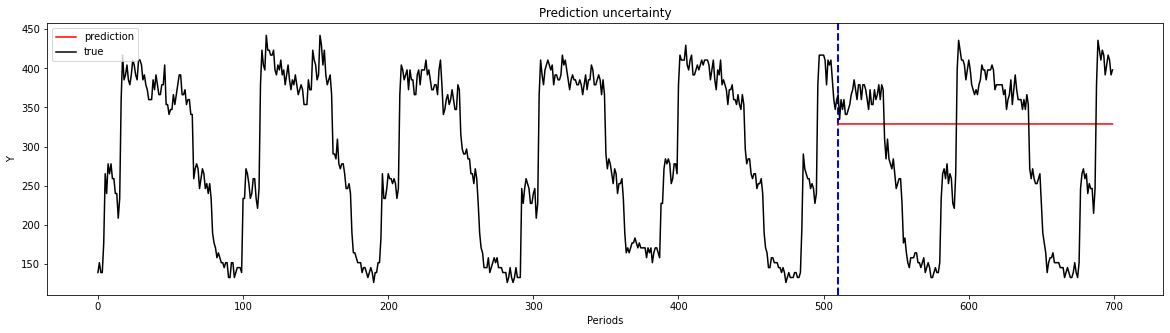

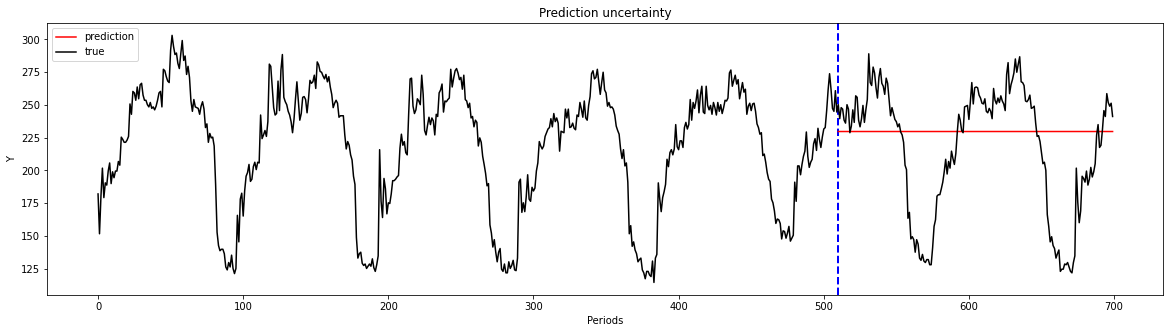

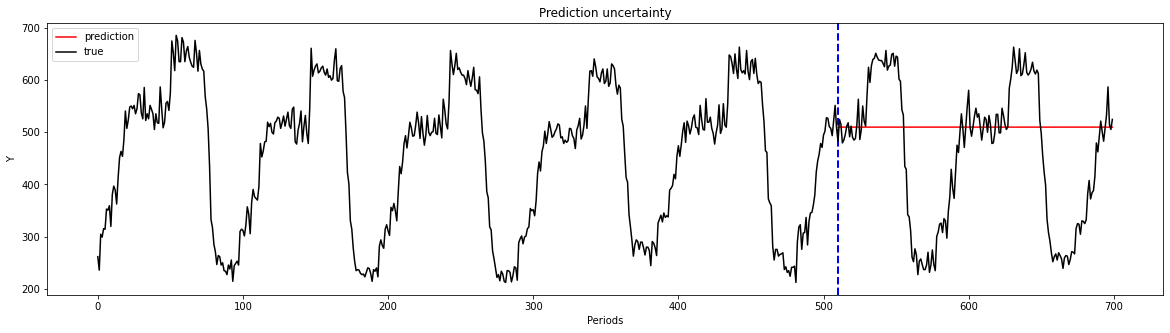

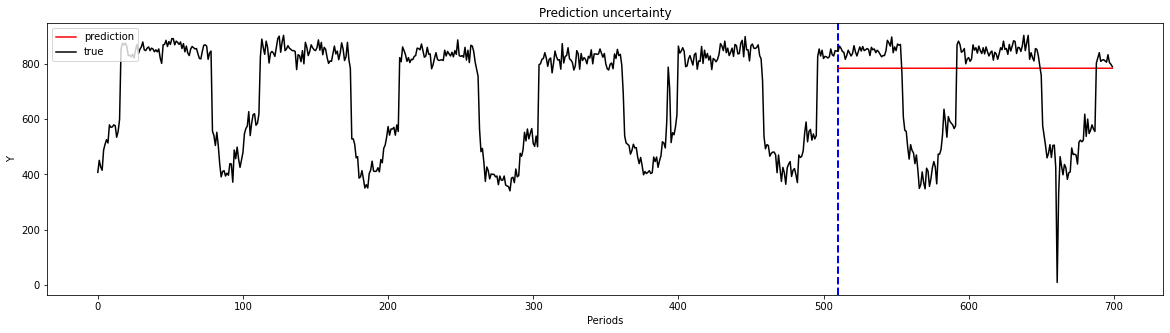

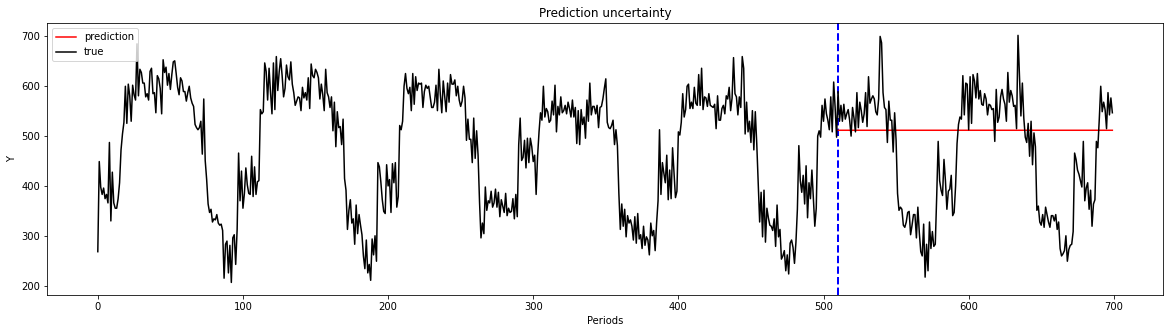

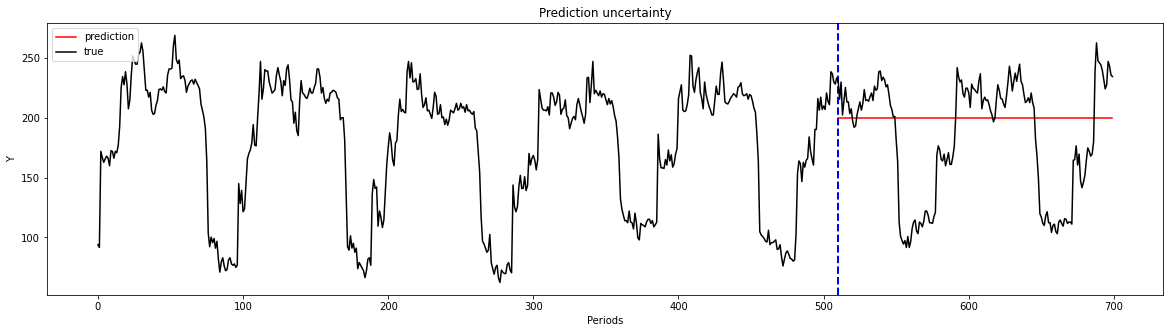

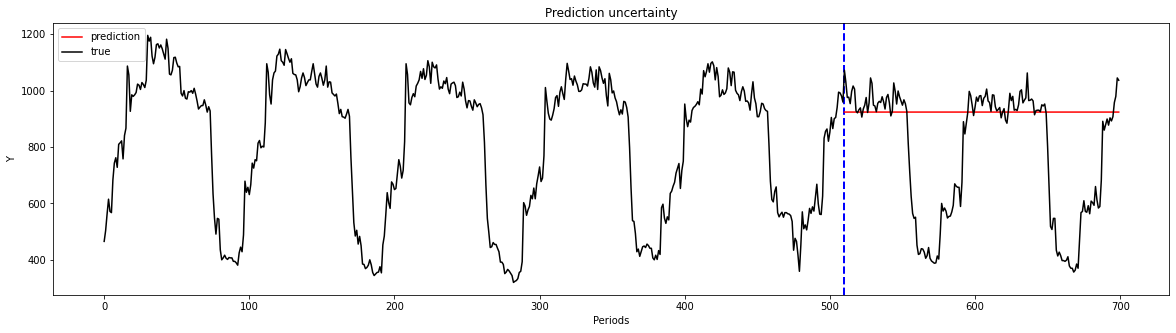

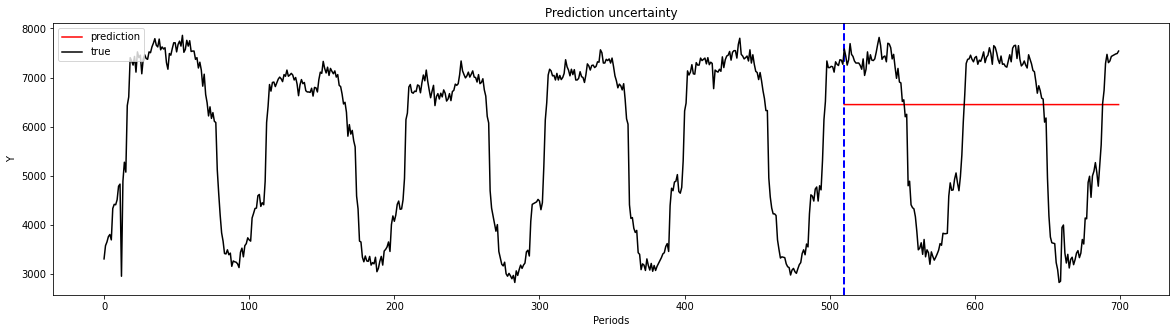

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 16.90s | valid loss 0.25731 | valid ppl     1.29
-----------------------------------------------------------------------------------------


/home/yinke/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   2 |    16/   84 batches | lr 0.004802 | 154.68 ms | loss 0.26733 | ppl     1.31
| epoch   2 |    32/   84 batches | lr 0.004802 | 147.80 ms | loss 0.23212 | ppl     1.26
| epoch   2 |    48/   84 batches | lr 0.004802 | 126.83 ms | loss 0.26506 | ppl     1.30
| epoch   2 |    64/   84 batches | lr 0.004802 | 139.74 ms | loss 0.24325 | ppl     1.28
| epoch   2 |    80/   84 batches | lr 0.004802 | 133.68 ms | loss 0.22308 | ppl     1.25
torch.Size([1030, 10]) torch.Size([1030, 10])


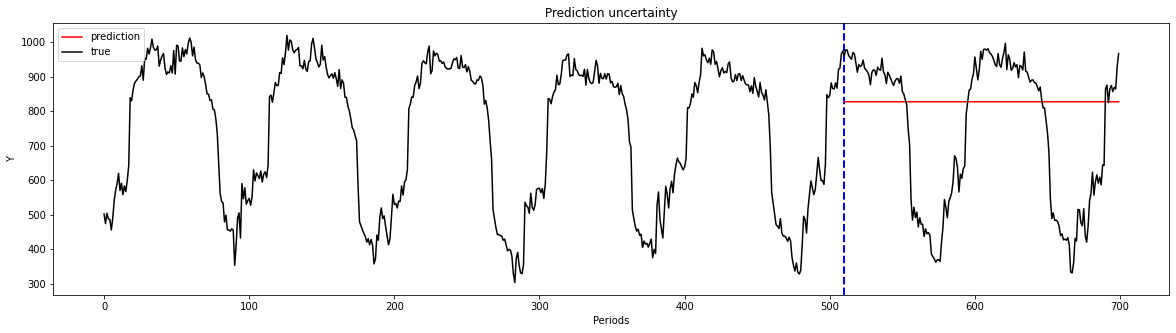

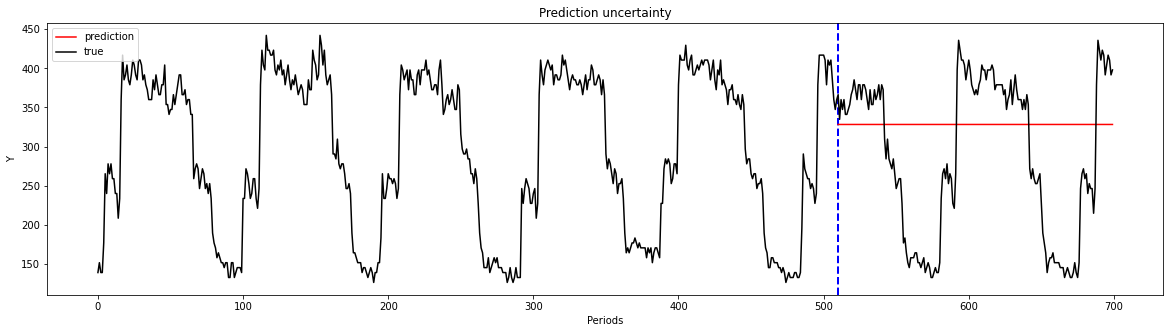

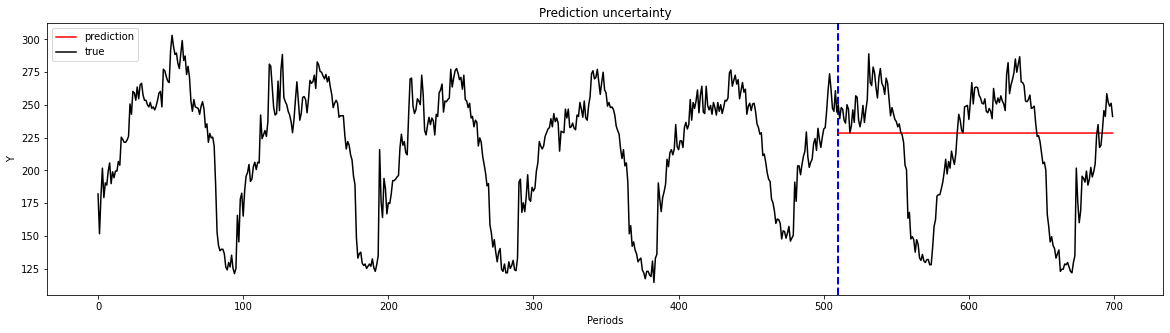

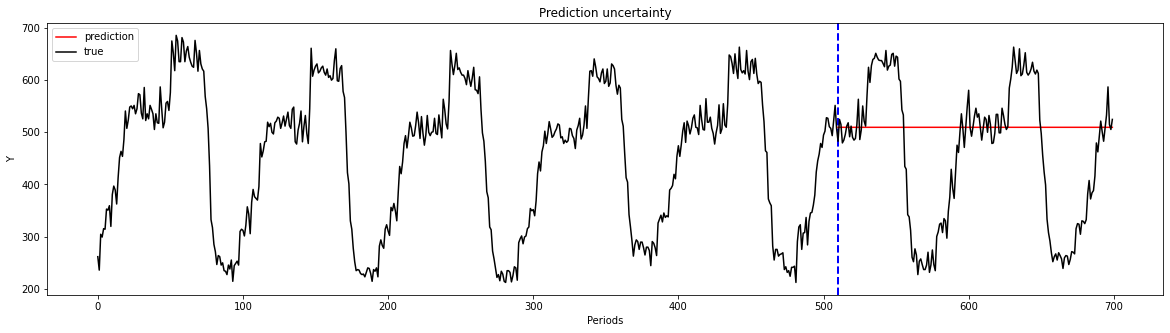

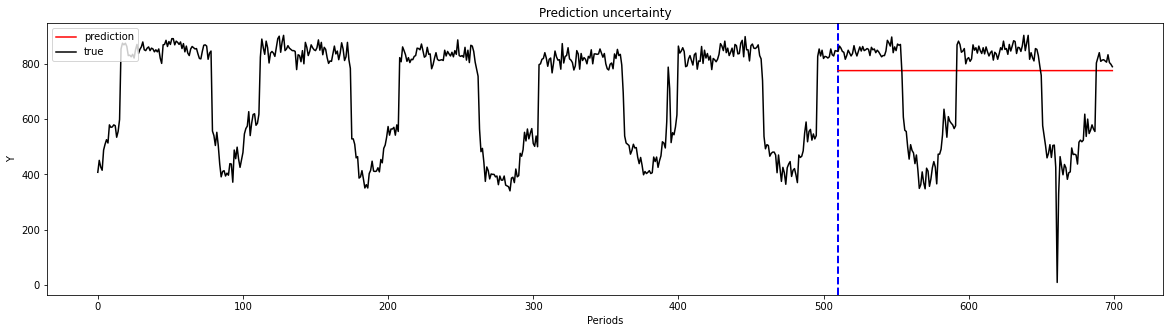

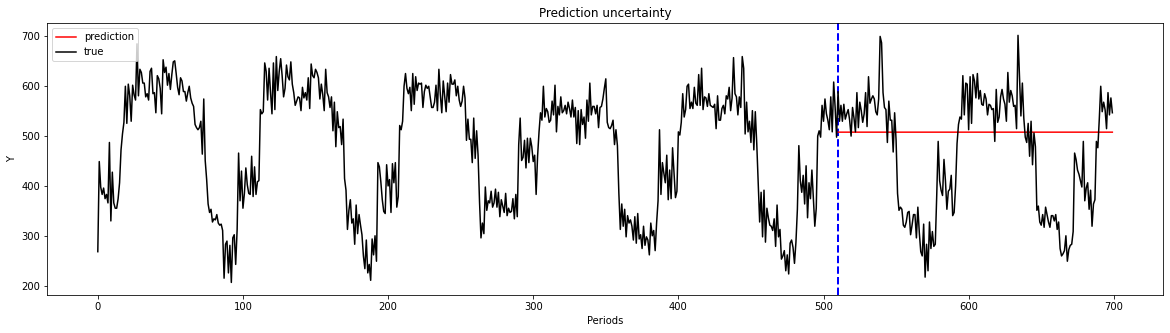

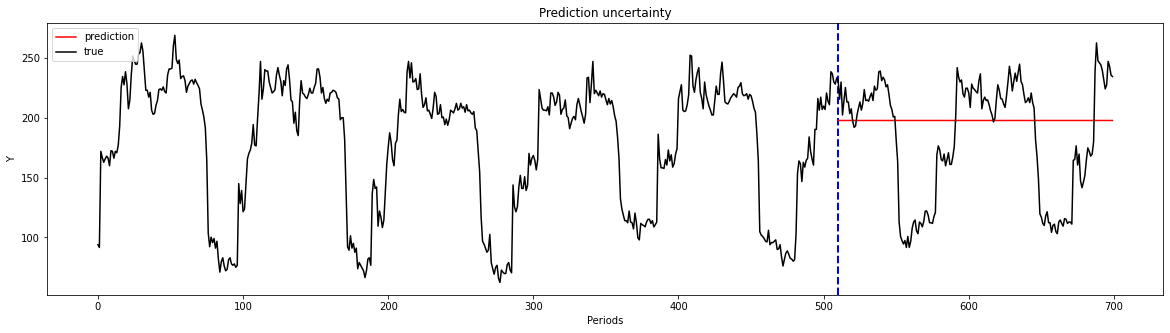

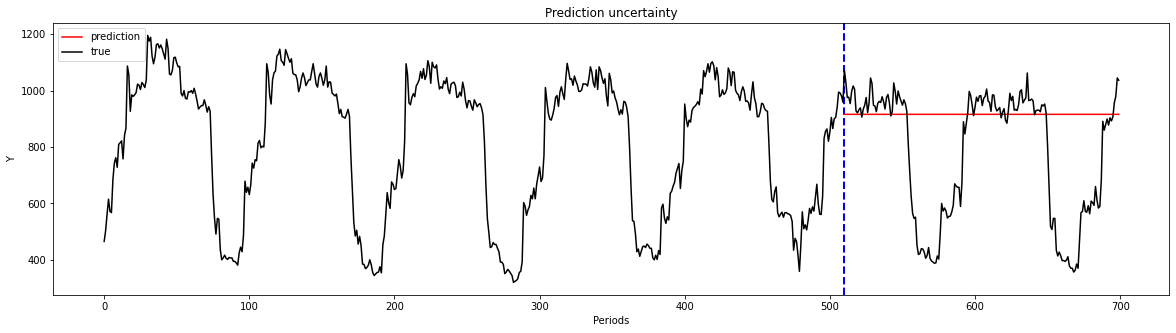

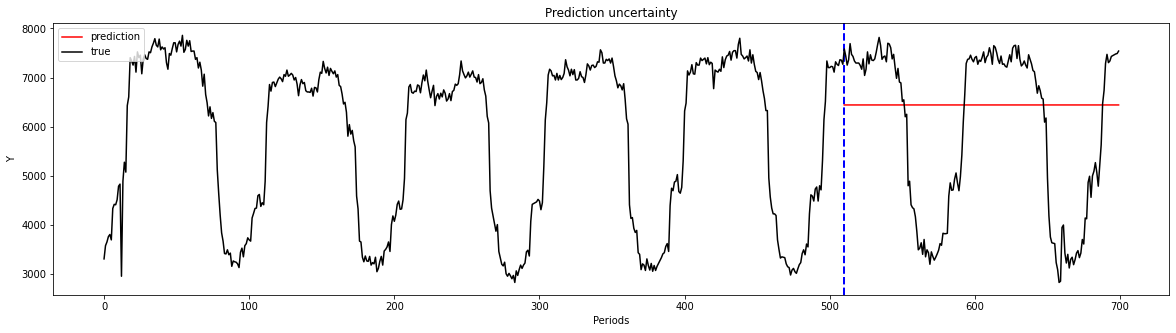

-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 15.75s | valid loss 0.25474 | valid ppl     1.29
-----------------------------------------------------------------------------------------


/home/yinke/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   3 |    16/   84 batches | lr 0.004706 | 144.62 ms | loss 0.26548 | ppl     1.30
| epoch   3 |    32/   84 batches | lr 0.004706 | 136.39 ms | loss 0.23057 | ppl     1.26
| epoch   3 |    48/   84 batches | lr 0.004706 | 143.79 ms | loss 0.26362 | ppl     1.30
| epoch   3 |    64/   84 batches | lr 0.004706 | 140.97 ms | loss 0.24221 | ppl     1.27
| epoch   3 |    80/   84 batches | lr 0.004706 | 140.76 ms | loss 0.22204 | ppl     1.25
torch.Size([1030, 10]) torch.Size([1030, 10])


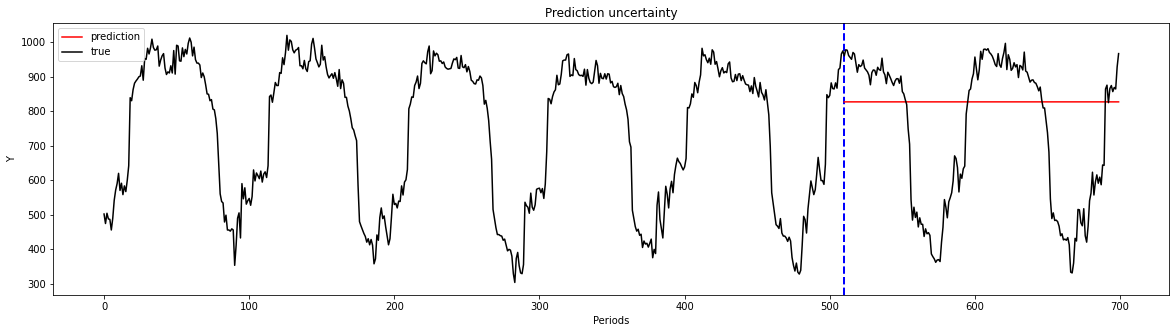

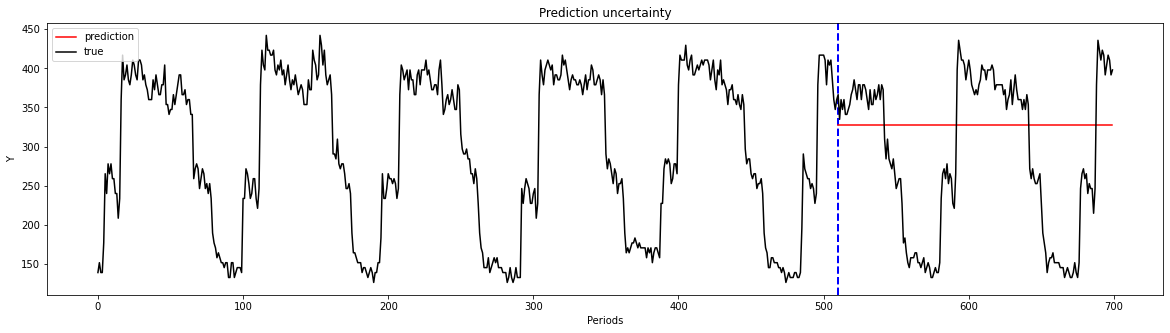

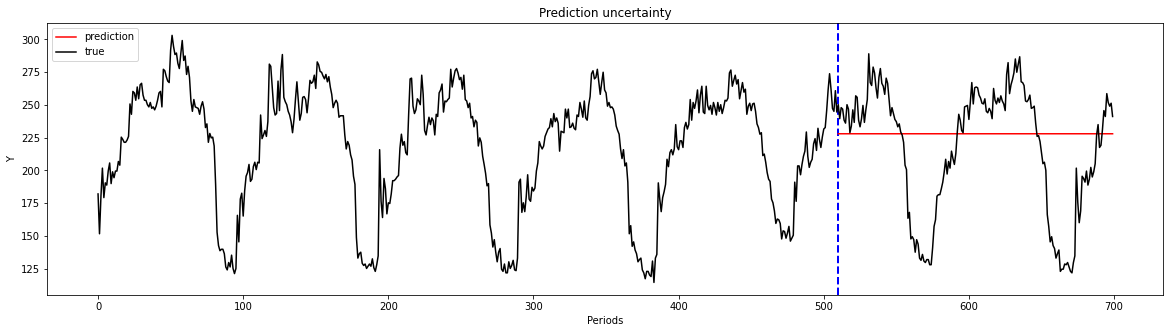

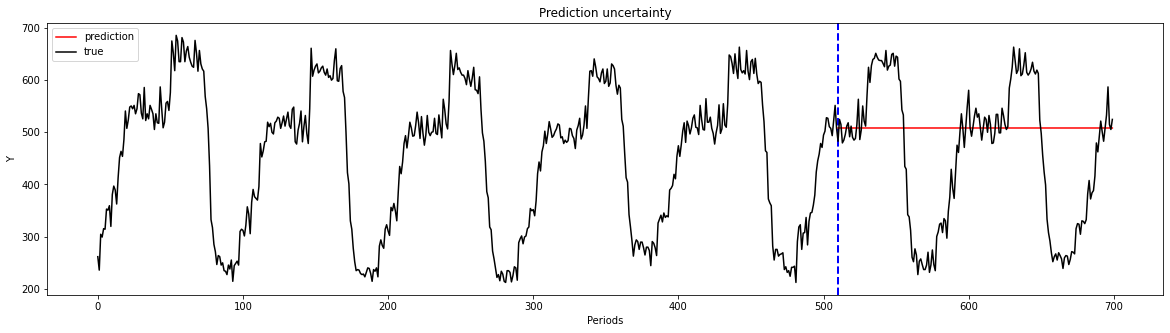

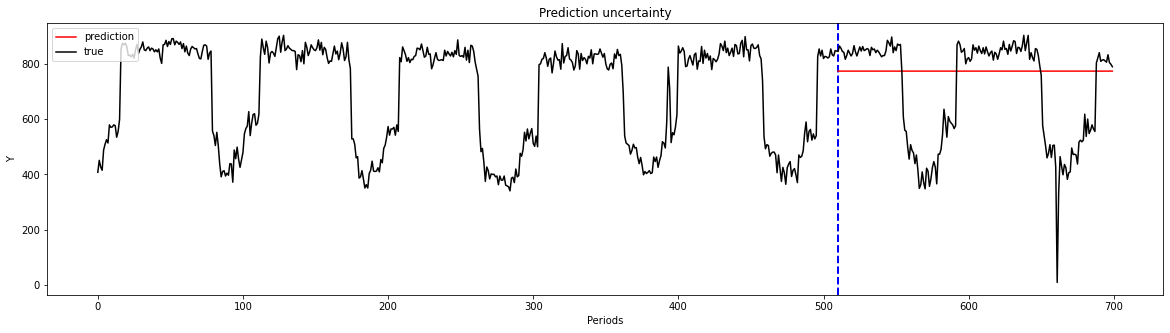

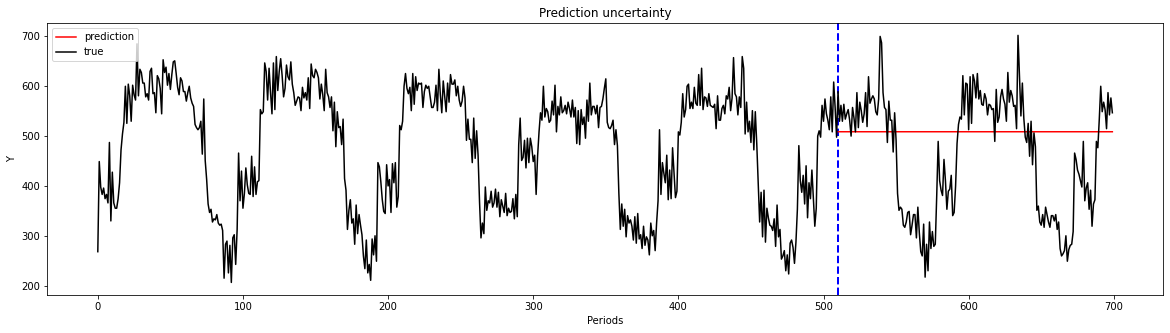

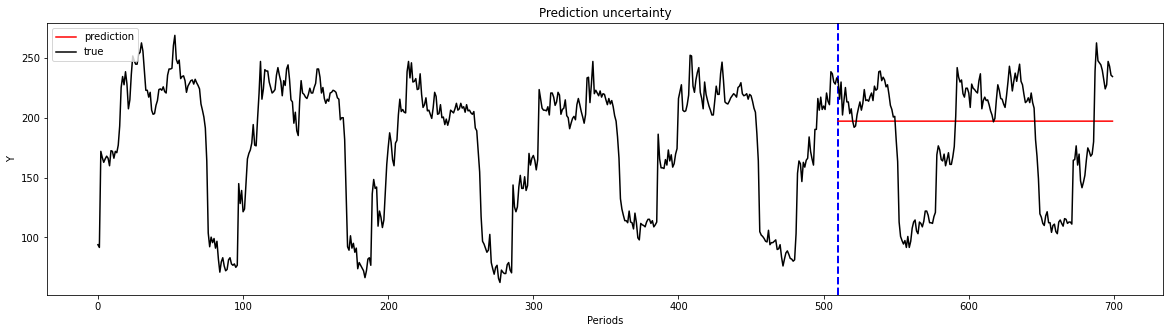

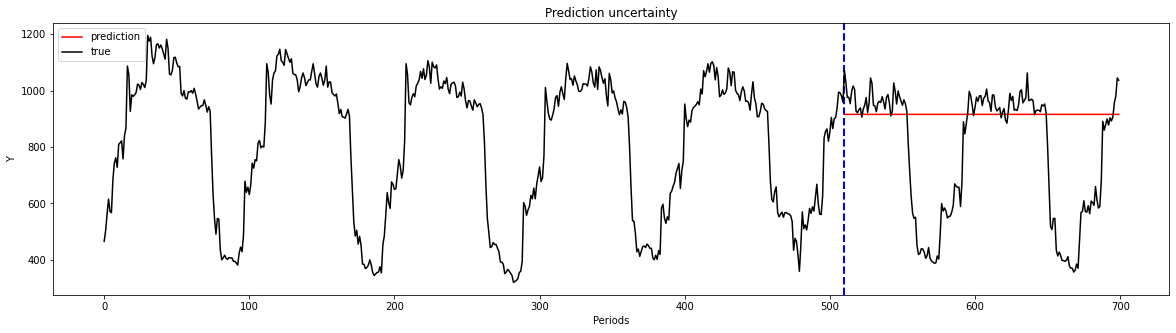

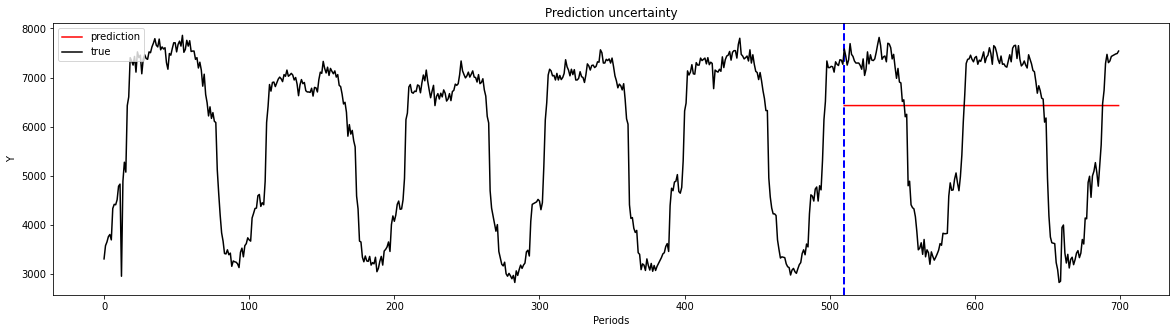

-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 16.04s | valid loss 0.25383 | valid ppl     1.29
-----------------------------------------------------------------------------------------


/home/yinke/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   4 |    16/   84 batches | lr 0.004612 | 149.77 ms | loss 0.26461 | ppl     1.30
| epoch   4 |    32/   84 batches | lr 0.004612 | 147.47 ms | loss 0.22937 | ppl     1.26
| epoch   4 |    48/   84 batches | lr 0.004612 | 143.29 ms | loss 0.26226 | ppl     1.30
| epoch   4 |    64/   84 batches | lr 0.004612 | 141.02 ms | loss 0.24131 | ppl     1.27
| epoch   4 |    80/   84 batches | lr 0.004612 | 142.42 ms | loss 0.22063 | ppl     1.25
torch.Size([1030, 10]) torch.Size([1030, 10])


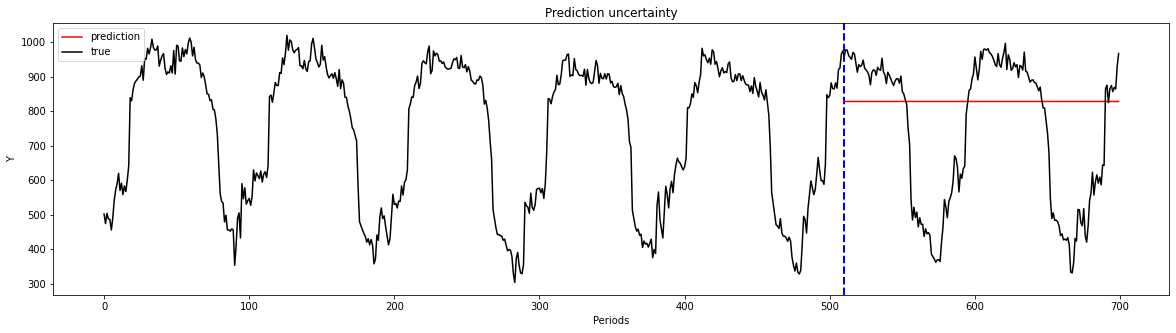

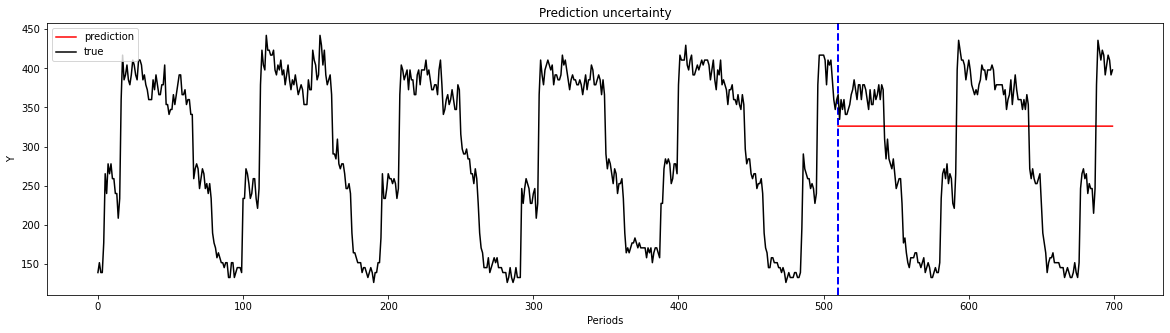

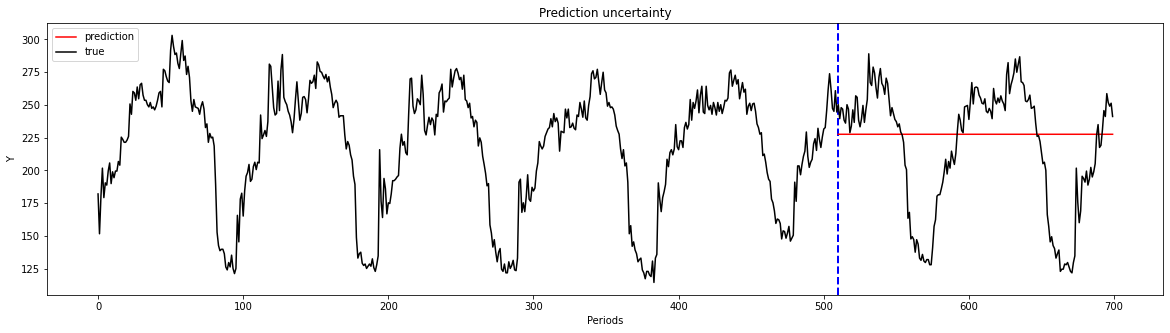

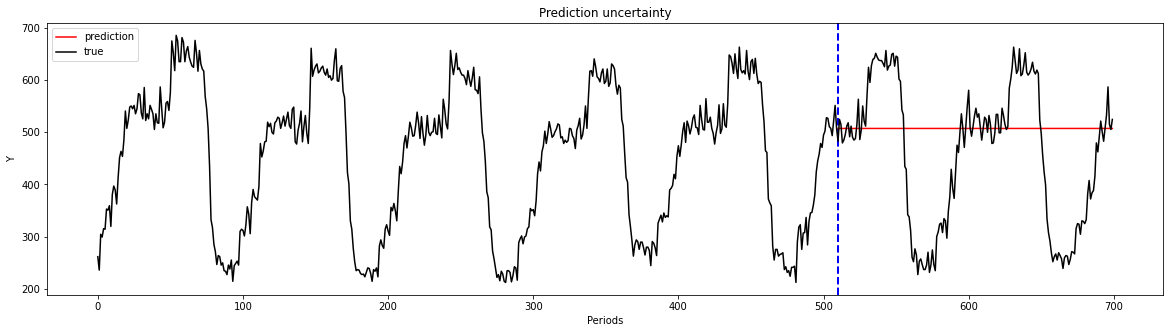

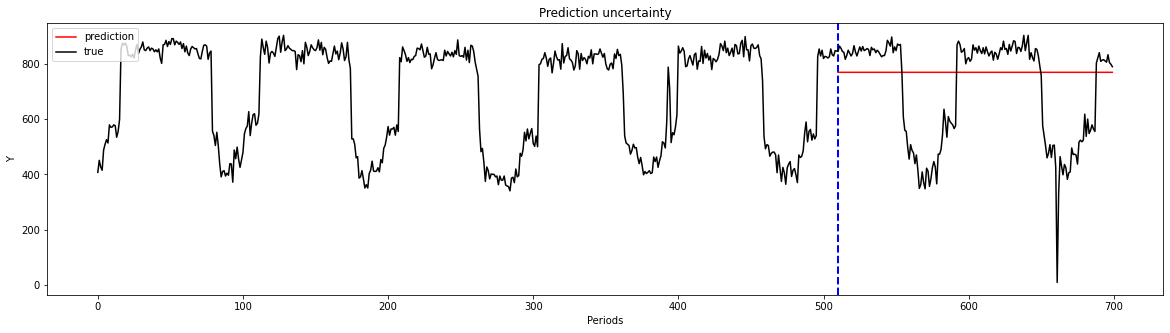

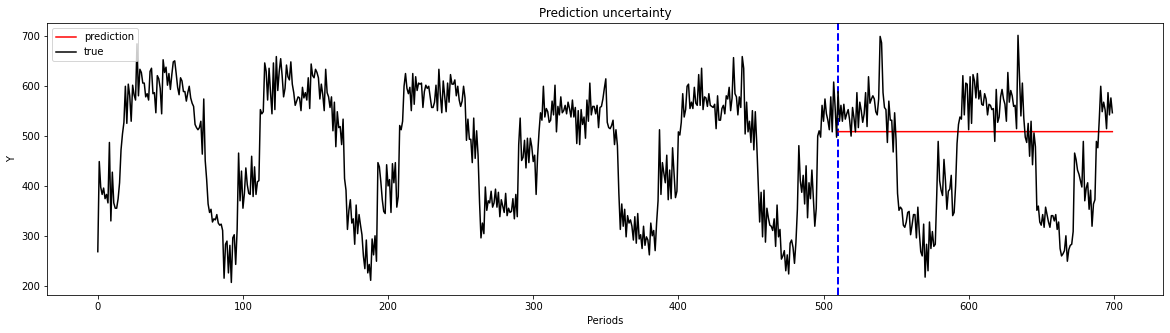

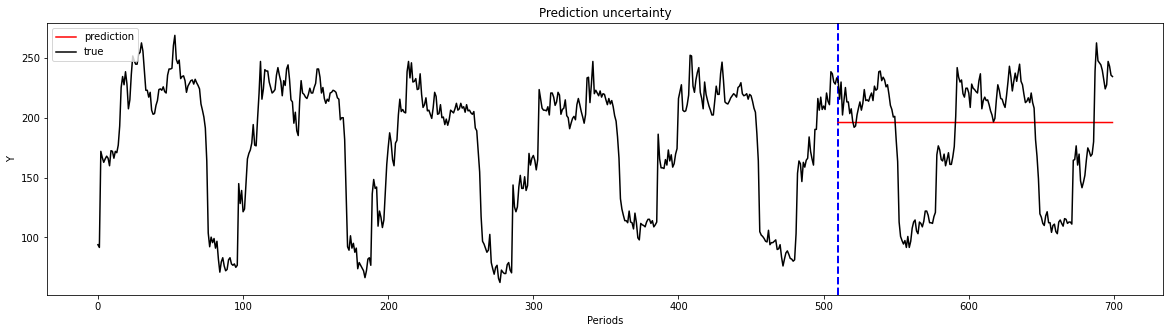

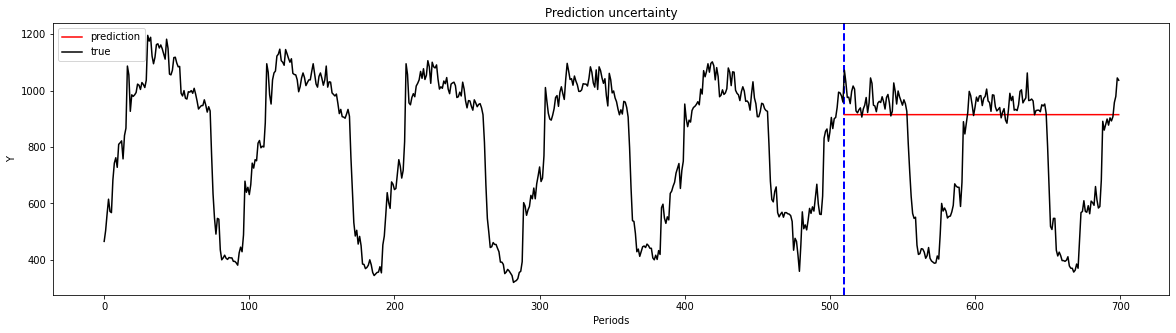

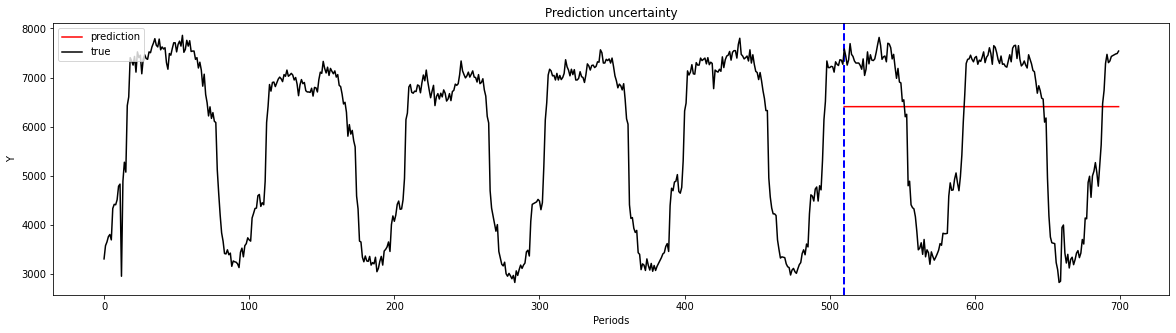

-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 16.72s | valid loss 0.25262 | valid ppl     1.29
-----------------------------------------------------------------------------------------


/home/yinke/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   5 |    16/   84 batches | lr 0.004520 | 150.43 ms | loss 0.26361 | ppl     1.30
| epoch   5 |    32/   84 batches | lr 0.004520 | 142.99 ms | loss 0.22940 | ppl     1.26
| epoch   5 |    48/   84 batches | lr 0.004520 | 140.41 ms | loss 0.26266 | ppl     1.30


KeyboardInterrupt: 

In [21]:
train_data, val_data,scaler = get_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 20 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 1 is 0):
        val_loss = plot(model, val_data,epoch,scaler)
        # predict_future(model, val_data,200,epoch,scaler)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 